## Questions of interest 

Hotel industry is a complicated field for data analysis. Hotel performance depends on a lot of variables: location, room types distribution, meals, tour operators, time of the year flights capacity, etc.

Booking data is the one of the most granular data in the hotel industry from the perspective of the revenue: one can disclose time paterns or try to predict outcomes like wheter a booking will end up in a cancellation.

We'll try to use an open dataset with information of two real hotels to answer questions of interest regarding the industry, and those hotels in particular.

This analysis takes data from a [Kaggle dataset](https://www.kaggle.com/jessemostipak/hotel-booking-demand) that in turns takes it from [siencedirect.com](https://www.sciencedirect.com/science/article/pii/S2352340918315191). It's real booking data from two hotels in Portugal: one resort hotel and one city hotel, with arrivals from july 2015 to august 2017, including a total of 21 variables. For more detail information about the dataset you can go visit the [dataset from Kaggle](https://www.kaggle.com/jessemostipak/hotel-booking-demand)

There are three question that this analyisis will try to solve and that there are important from a business perspective.

**1. How strong is the seasonality in the hotels?**

Hotels, spetially resort hotels are known to have strong seasonality. If you are managing one of this hotels or if you want to introduce yourself in a market, a very basic point is to understand the seasonality patterns. ¿how strong is the seasonality? ¿When does the 'summer season' beggins in this location (April, May, ...)?

**2. Up to what point adr, length of stay and lead time for groups reservation difers from individual / transient ones?**

This question is important from the revenue point of view: if groups usually make reservations with a lot of antelation, they could by at a cheaper price, since ussually there are erly booking offers, and prices tend to be higher when there is little antelation. In this situation, an hotelier can have an hotel nearly at the top of its capacity for a series of consecutive nights, that have been sold at a very low price, because a group made the reservation well on advance. Moreover, if a group comes to an event that takes place for only two days, say tuesday and wenedsday (in the middle of the week), and this group makes for 80 or 90 % of the hotel rooms, in some hotels it will me more difficultto fill up the hotel for that particular week. It will be more difficult to sell a room when you are forced to sell it "from thursday to sunday". For this reason sometimes the price for a group should be higher than the average rate.

**3. Can we predict a cancellation, just with the information available at the moment this reservation has been made?**

If we can predict wether or not a booking will be cancelled we can target this client (if posible) for specific marketing campaigns for clients that will likely cancel a reservation if no action is taken.

## Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt, timedelta
import statsmodels.api as sm
import calendar
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

## Helper functions

Below, there are several functions created specifically for this analysis.

In [2]:
def compute_main_kpis(dat, grouping_variables):
    
    ''' 
    Computes common KPIs (revenue, roomnights, adr) for any given level of aggregation from a DataFrame
    ASSUME:  the DataFrame includes the colum lenght_of_stay, revenue and roomnights
    
    INPUTS
        - dat: DataFrame with booking data
        - grouping_variables: list of variables whose grouping is the basis of the computation
        
    OUTPUT:
        - Data frame with columns 'revenue', 'roomnights' and 'ADR' grouped by grouping_variables
    ''' 
    
    # computes revenue
    dat = dat.groupby(grouping_variables).agg({"length_of_stay": "sum",  "revenue": "sum"})
    
    # computes roomnights
    dat = dat.rename(columns = {'length_of_stay': 'roomnights'})
    
    # computes ADR
    dat["adr"] = dat["revenue"] / dat["roomnights"]
    
    return dat


def resample_time_kpis(dat, order):
    
    '''
    Computes coomon kPIs  from any given booking DataFrame with a DateTime index, resampling the DataFrame by 
    the order specified in 'order'.
    
    The difference between this function and compute_main_kpis is that when we group by Date we have an DateTime index from which we 
    can perform time series operations like compute the seasonal index.
    
    INPUTS
        - dat: DataFrame with a datetime index
        - order: resample order
        
    OUTPUT
        DateTime indexed DataFrame with columns 'roomnights', 'revenue' and 'adr'
    
    ''' 
    
    # computes roomnights and revenue
    dat = dat.resample(order).agg({'roomnights': 'sum', 'revenue': 'sum'})
    
    # computes adr
    dat['adr'] = dat['revenue'] / dat['roomnights']
    
    return dat

def relativize_kpi(dat, kpi):
    
    '''
    Divides numeric series into its maximum value
    
    INPUTS
        - dat: DataFrame
        - kpi: column we want to relativize
        
    ''' 
    
    return dat[kpi] / max(dat[kpi])


def compute_mavg(df, variable, k = 7): 
    
    '''Computes moving average from a numerical column from a given DataFrame
    
    INPUTS
        - df: DataFrame
        - variable: str. Name of the column in the DataFrame
        - k: int. Rolling average order
        
    OUTPUTS
        Serires with the computed rolling average
    '''
    
    
    return df[variable].rolling(window = k).mean()

def compute_seasonality_strength(decomp_series):
    
    '''
    Computes Seasonality strengh from a decomposed time series according to the method available in the
    following link: https://otexts.com/fpp2/seasonal-strength.html
    
    INPUT
        -decomp_series: an statsmodels.tsa.seasonal object with seasonal data
        
    OUTPUT
        - numeric score
    '''
    
    return 1 - np.var(decomp_series.resid) / (np.var(decomp_series.resid) + np.var(decomp_series.seasonal))


def filter_confirmed(dat):
    
    '''Filters confirmed reservations from a DataFrame dat
    ASSUME: dat has a binary 'is_canceled' columns with values 0 for non canceled and 1 for canceled bookings
    
    IMPUT
        - dat: DataFrame to be filtered
        
    OUTPUT
        - A filtered version of the imput DataFrame with canceled bookings removed
    '''
    return dat[dat['is_canceled'] == 0]



def arrival_to_stay(ser, group_vars = None):
    
    '''
    Takes a series with an arrival date and a length of state and creates a data frame expanding the arrival date to stay dates.
    i.e: if the lenght of stay is 3, the data frame will have three rows. Creates additional rows replicating other values from the series
    
    The function is meant to be used taken an individual row from the bookigns data sets in this analysis
    
    IMPUTS
        - ser: Pandas series. It's mean to be a row from a booking DataFrame loaded or created in this analysis
        - group_vars: additional columns to include in the data frame besides stay_date
        
    OUTPUTS
        - Pandas DataFrame
    '''
        
    # lenght of stay extraction
    los = ser['length_of_stay']
    
    # gets intiial stay date
    arrival_date = ser['arrival_date']
    
    # creates a range of consecutive dates taking arrival_date as first date 
    # and arrival_date + los as the last date. As we count nights not days, last day is substracted
    # exect when length of stay is 0
    days = pd.date_range(arrival_date, arrival_date + timedelta(days = int(los - 1 * (los > 0))))
    
    # helper function to create arrays with repeated values
    def expand_point(point):
        return np.repeat(ser[point], los + (los == 0) * 1)
    

    
    # creating a data frame with stay_dates and repeated vallues from important kpis or dimensions
    dat = pd.DataFrame(data = {'stay_date': days,
                               'roomnights': np.repeat((los > 0) * 1, los + (los == 0) * 1),
                               'revenue': expand_point("adr")
                                  }
                      )
    
    
    # include additional columns in the DataFrame
    df_add_cols = pd.DataFrame()
    
    if group_vars is not None:
        for name in group_vars:
            df_add_cols[name] = expand_point(name)
    
    dat = pd.concat([dat, df_add_cols], axis = 1) 
 
    return dat
    
    
def get_daily_data(booking_data, group_vars = None):
    
    
    '''
    Aggregates a bookings dataset to a daily dataset where the dates are stay dates, not arrival dates.
    Employs "arrival_to_stay" function to expand each booking into a DataFrame with the number of rows equal to the 
    number of nights. Three daily kpis are obtained as a result of this aggregation: roomnights, revenue and adr
    
    IMPUT
        - booking_data: DataFrame with bookings
    
    OUTPUT
        - DataFrame with daily aggregated data
        - group_vars: optional additional variables used for grouping when computing the daily data
    
    '''
    
    # creates a list of DataFrames, each one being a booking row from the input data, which has been expanded
    # with the function arrival_to_stay
    expanded_data_list = [arrival_to_stay(booking_data.loc[row, :], group_vars) for row in range(booking_data.shape[0])]
    
    # concatenates the previous list into one DataFrame
    stay_data = pd.concat(expanded_data_list, axis = 0)
    
    group_list =['stay_date']
    
    if group_vars is not None:
        group_list.extend(group_vars)

    
    # groups data by date, obtaining roomnights and revenue
    daily_data = stay_data.groupby(group_list).agg({'roomnights':'sum',
                                                     'revenue': 'sum'}).reset_index()
    
    # computes adr from roomnights and reveue
    daily_data['adr'] = daily_data['revenue'] / daily_data['roomnights']
    
    # creates month and week columns
    daily_data['stay_month'] = daily_data['stay_date'].dt.month
    daily_data['stay_week'] = daily_data['stay_date'].dt.week
    
    # creates DateTime Index with stay_date
    daily_data = daily_data.set_index('stay_date')
    
    return daily_data


def plot_cancel_prop(df, var, grouping_var = "hotel", aspect = 1, rot = 0):
    
    '''Automatizes category chart creation to summarize proportion of cancelations grouped by a variable introduced 
    by the user. It is also posible to create an additional grouping with subplots.
    
    It also returns the proportion for each one of the grouping variable categories
    
    ASSUME: the data to create the plot is a bookings DataFrame which includes the variables 'is_canceled' and 'hotel'
    
    IMPUTS
        - df: DataFrame from which the data to create the plot is taken
        - var: variable to group the results
        - grouping_var: varible to create subplots
        - aspect: plot width
        - rot: rotation of x axis
    '''
    
    # computes variable categories proportion
    prop_categories = df[var].value_counts() / sum(df[var].value_counts())
    
    # creates plot               
    g = sns.catplot(x = var, y = 'is_canceled',
                                        data = df, kind = "bar", col = grouping_var,
                                        col_wrap = 2, aspect = aspect)
    
    # rotates x axis labels
    g.set_xticklabels(rotation= rot)
    
    return prop_categories, g


def plot_rolling_average_series(data1, kpi, label1, title, data2 = None, label2 = None,
                                style = 'seaborn', width = 16, height = 7, alpha = 0.4,
                                roll_window = 7):
    
    '''Plots a time series data and a rooling average for a numeric column from a DataFrame with a DateIndex. 
    Optionally plots a second time series from a second data frame
    
    IMPUTS
        - data1: DataFrame with a DateIndex
        - kpi: numeric column in data1
        - label1: string with legend label for data1
        - title: string with plot title
        - data2 DataFrame with a DateIndex
        - label2: string with legend label for data2
        - style: string with matplotlib plot style
        - width: float. Plot width
        - height: float. Plot height,
        - alpha: float. Rolling average series transparency
        - roll_window: int. Window for rolling average
        
    OUTPUTS
        - matplotlib.pyplot
    
    '''
    
    # set style, figure and axes
    plt.style.use(style)
    fig, ax = plt.subplots(figsize = (width, height))
    
    # plots originar series and rolling average
    ax.plot(data1.index, data1[kpi], alpha = 0.4)
    ax.plot(data1.index, data1[kpi].rolling(window = roll_window).mean(), label = label1)
    
    # plots a second series if it exists
    if data2 is not None:
        ax.plot(data2.index, data2[kpi], alpha = 0.4)
        ax.plot(data2.index, data2[kpi].rolling(window = roll_window).mean(), label = label2)
    
    # title and legend
    plt.title(title, loc = 'center')
    plt.legend(loc = 'upper left')
    
    plt.show()
    
def plot_normalized_seasonality(dec_series, ax):
    
    '''Plots a normalized sasonality component from a decomposed time series
    
    INPUTS
        - dec_series: decomposed time series
        - ax: plot ax object
        
    OUTPUTS
        - Prints a plot
        
        
    '''
    
    (dec_series.seasonal / dec_series.seasonal.std()).plot(ax = ax)

    
    
def sort_categories_distrib(df, var):
    
    '''Assigns relative frequency and cumulative relative frequency for each category of an object column in a data frame
    and sorts it from higher to lower frequency
    
    INPUTS
    
        - df: DataFrame with the column to sort
        - var: column to sort
    
    OUTPUT
    
    DataFrame with sorted relative frequencies
    '''
    
    # series of sorted values with frequencies
    sorted_categories = df[var].value_counts().sort_values(ascending = False)
    
    # computes relative frequency
    sorted_categories = pd.DataFrame(data = sorted_categories / sum(sorted_categories)).rename(columns = {var:"f"})
   
    # computes cumulative relative frequency
    sorted_categories['F'] = sorted_categories.f.cumsum()
    
    return sorted_categories


def group_main_categories(df, var, n_categories):
    
    ''' Groups less frequent categories in an object column from a DataFrame assigning them the value "other"
    making use of the sort_categories_distrib function. 
        
    
    IMPUTS
        - df: DataFrame with column to group
        - var: column to group
        - n_categories: Threshold. Number of most frequent categories that won't be grouped.
    '''
    
    # gets most frequent categories
    main_categories = sort_categories_distrib(df, var).head(n_categories).index
    
    # groups categories if they are not among the most frequent ones
    return [categorie if categorie in main_categories else "other" for categorie in df[var]]
    
    
def get_seasonal_dataframe(dec_series, columns = None):
    
    '''Takes a decomposed time series, takes the seasonal component, computes an standarized version of it
    and creates a DataFrame with these computations and additional constant columns added by the user
    
    IMPUTS
        - seasonal.DecomposeResult: the decomposed time series
        - colums: dictionary with the names of the new constant columns and its constant value
    
    '''
    
    # get seasonal component
    seas_df = pd.DataFrame(dec_series.seasonal)
    
    # standarize seasonal component
    seas_df['seas_standarized'] = seas_df['seasonal'] / (seas_df['seasonal']).std()
    
    # adding constant columns when provided
    if columns is not None:
        
        for key in columns.keys():
            
            seas_df[key] = columns[key]
    
    # reset index
    seas_df.reset_index(inplace = True)
    
    return seas_df

## Load Data

In [3]:
# getting data
bookings = pd.read_csv('hotel_bookings.csv', parse_dates = True)

## Pre-exploration

In [4]:
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

There are some columns with missing values. "agent" seems to be almost unsusable. It only has 6797 non-null cases. There are no missing values in variables of spetial interest: variables related with arrival_date, customer_type (the variable which includes groups, for the second question in the analysis) and is_canceled: the variable to determine wether a booking has been canceled.

**Inspecting the data**

In [5]:
bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Wrangling /cleaning

### Constants 

We'll now set some constanst that will be used through the analysis, mainly in visualizations, for ordering axis or facets

In [6]:
ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", 
                 "October", "November", "December"]

ordered_rooms = np.sort(bookings.assigned_room_type.unique())

# month mapping (from numbers to names)
month_mapping = {v: k for k,v in enumerate(calendar.month_name)}

### Basic feature creation

Below new features are created, mostly related with dates, but also variables related with revenue and length of stay

In [7]:
# arrival_date
bookings["arrival_date"] = bookings["arrival_date_year"].astype(str) + bookings["arrival_date_month"] + bookings["arrival_date_day_of_month"].astype(str)
bookings["arrival_date"] = bookings["arrival_date"].apply(lambda x: dt.strptime(x, "%Y%B%d"))

# length_of_stay as the sum of stays in weekdays and stays in weekends
bookings['length_of_stay'] = bookings['stays_in_weekend_nights'] + bookings['stays_in_week_nights']

# intervals for lenght_of_stay
bookings['los_int'] = pd.cut(bookings.length_of_stay, bins = range(1,30, 2))

# departure date
bookings['departure_date'] = bookings.apply(lambda x: x.arrival_date + timedelta(days = x.length_of_stay), axis = 1)

# booking date
bookings['booking_date'] = bookings.apply(lambda x: x.arrival_date - timedelta(days = x.lead_time), axis = 1)
bookings['booking_month'] = bookings['booking_date'].apply(lambda x: x.strftime('%b'))

# revenue = adr * length of stay
bookings['revenue'] = [los * adr if los > 0 else adr for los, adr in zip(bookings['length_of_stay'], bookings['adr'])]

# lead_time_weeks
bookings['lead_time_weeks'] = bookings['lead_time'].apply(lambda x: x // 7)

# weekday check in and check out
bookings['weekday_checkin'] = bookings['arrival_date'].dt.weekday
bookings['weekday_checkout'] = bookings['departure_date'].dt.weekday

# creation of variable group
bookings['group'] = bookings.customer_type == "Group"



### Data split: city hotels and resort hotels 

For the first and second cuestion,  sometimes it will make sense to have additional 'city' and 'resort' datasets, since I think it's possible for this hotels to have a different behavior regarding those cuestions.

In [8]:
city = bookings[bookings["hotel"] == "City Hotel"]
resort = bookings[bookings["hotel"] == "Resort Hotel"]

### Filtering out cancelled bookings 

For the first two questions, we'll work with bookings that actually materialized in stays in the hotel, that is confirmed bookings

In [9]:
bookings_confirmed = filter_confirmed(bookings)
city_confirmed = filter_confirmed(city).reset_index()
resort_confirmed = filter_confirmed(resort).reset_index()

## **1. How strong is the seasonality in the hotels?**

### Wrangling: reestructure data

We'll proceed now to restructure the data and compute roomnights, revenue and adr per **stay day**, that is how many roomnight and how much revenue there is in an specific date.

In [10]:
# getting daily data
bookings_daily = get_daily_data(bookings_confirmed.reset_index(), ["hotel"])
resort_daily = bookings_daily[bookings_daily.hotel == "Resort Hotel"]
city_daily = bookings_daily[bookings_daily.hotel == "City Hotel"]

In [11]:
bookings_daily.head()

,hotel,roomnights,revenue,adr,stay_month,stay_week
stay_date,,,,,,
2015-07-01,City Hotel,65,6180.00,95.076923,7,27
2015-07-01,Resort Hotel,36,3356.83,93.245278,7,27
2015-07-02,City Hotel,66,6238.67,94.525303,7,27
2015-07-02,Resort Hotel,64,6251.33,97.677031,7,27
2015-07-03,City Hotel,13,991.94,76.303077,7,27


### Modeling

#### Yearly Seasonality 

As daily data would probably be noisy, we'll compute the **weekly rolling average** for roomnights, revenue and adr

In [12]:
bookings_daily["roomnights_m7"] = compute_mavg(bookings_daily, "roomnights")
bookings_daily["revenue_m7"] = compute_mavg(bookings_daily, "revenue")
bookings_daily["adr_m7"] = compute_mavg(bookings_daily, "adr")

Below a three plots are displayed: daily adr, daily roomnights and daily revenue

C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


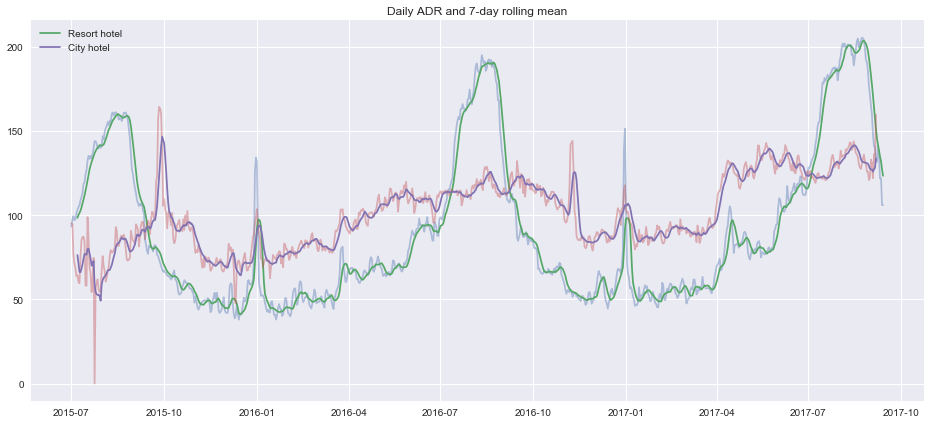

In [13]:
plot_rolling_average_series(resort_daily, "adr", "Resort hotel", title = "Daily ADR and 7-day rolling mean", data2 = city_daily,
                           label2 = "City hotel")

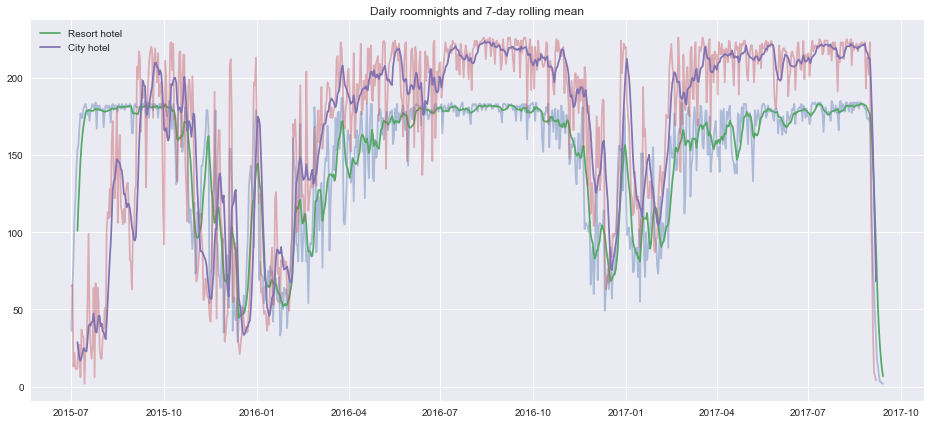

In [14]:
plot_rolling_average_series(resort_daily, "roomnights", "Resort hotel", title = "Daily roomnights and 7-day rolling mean", data2 = city_daily,
                           label2 = "City hotel")

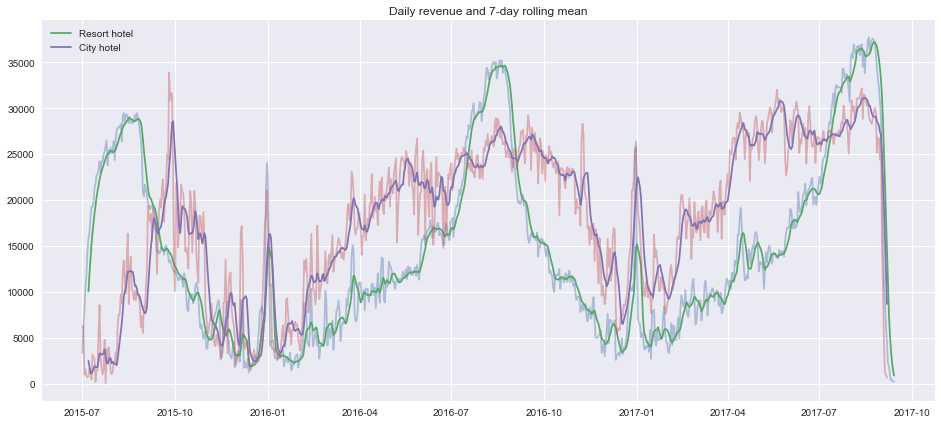

In [15]:
plot_rolling_average_series(resort_daily, "revenue", "Resort hotel", title = "Daily revenue and 7-day rolling mean", data2 = city_daily,
                           label2 = "City hotel")

While there seems to be strong seasonality patters in ADR for resort hotels, in city hotels that pattern, it is apparently not as stronger as it is in resort hotels.

Revenue follows a similar pattern

Regrarding roomnights, there is also seasonality (and the same patter change in July at the beginning of the series for the city hotel, though the decrease in roomnights for winter season is more abrupt.

#### Monthly seasonality

If we group the data by month the pottentials seasoanal behaviours can be spotted more clearly. In the case of the roomnights, if we take relative values instead of the raw number (that is, if we divide the roomnights by the maximum value, there is a simlilar (though not as pronounced) peak for roomnights in the central summer months, which couldn't be appreciated by looking to the daily data.

##### Monthly chart

In [16]:
# get number month
bookings_kpi_month = compute_main_kpis(bookings_confirmed,  ["arrival_date_month", "hotel"]).reset_index()

bookings_month_long = pd.melt(bookings_kpi_month, 
                              id_vars = ['arrival_date_month', 'hotel'], 
                              value_vars = ['roomnights', 'revenue', 'adr'],
                              var_name = 'kpi')

bookings_month_long['month_number'] = bookings_month_long['arrival_date_month'].apply(lambda x: month_mapping[x])

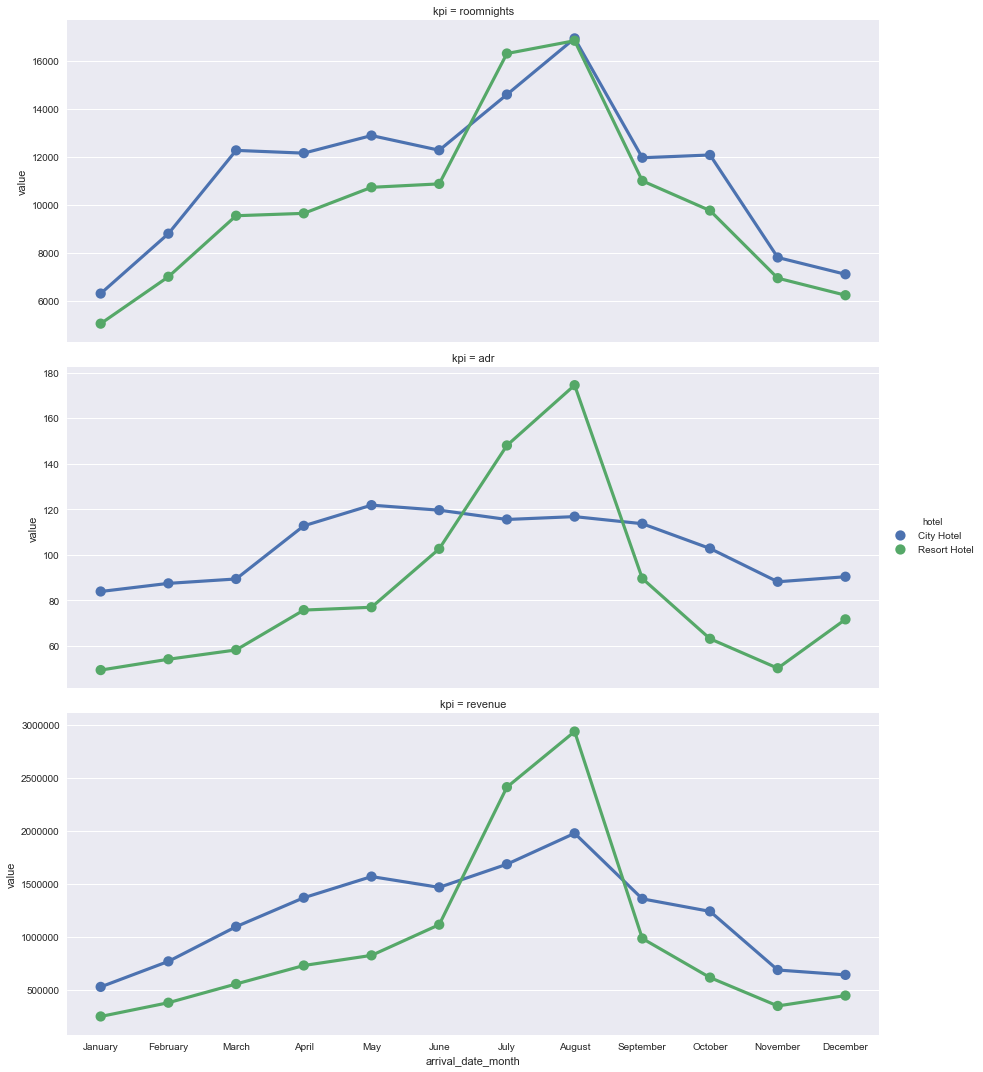

In [17]:
sns.catplot(data=bookings_month_long,
                   x='arrival_date_month',
                   y='value',
                   hue = 'hotel',
                   row='kpi',
                   row_order = ['roomnights', 'adr', 'revenue'],
                   sharey=False, 
                   aspect = 2.5,
                   kind = "point",
                   order = ordered_months,
                   s = 80,
                   alpha = 0.6)

#### Time series yearly seasonality 

We'll adopt a more formal approach decomposing a monthly time series into its components, then w we'll visualize the seasonality component and compute its strength

##### Seasonality visualization

First, we obtain the monthly time series for all kpis of interest

In [18]:
# getting monthly time series for main kpis
resort_kpi_time_month = resample_time_kpis(resort_daily, 'MS')
city_kpi_time_month = resample_time_kpis(city_daily, 'MS')

Then, we obtain the time series decomposition for each hotel and kpi

In [19]:
dec_resort_adr = sm.tsa.seasonal_decompose(resort_kpi_time_month[['adr']])
dec_city_adr = sm.tsa.seasonal_decompose(city_kpi_time_month[['adr']])

dec_resort_rn = sm.tsa.seasonal_decompose(resort_kpi_time_month[['roomnights']])
dec_city_rn = sm.tsa.seasonal_decompose(city_kpi_time_month[['roomnights']])

dec_resort_rev = sm.tsa.seasonal_decompose(resort_kpi_time_month[['revenue']])
dec_city_rev = sm.tsa.seasonal_decompose(city_kpi_time_month[['revenue']])


Finally, we plot the data combining the decomposed series in a DataFrame and adding new information

In [20]:
seas_df = pd.concat([
    get_seasonal_dataframe(dec_resort_adr, {'hotel': 'Resort hotel', 'kpi': 'adr'}),
    get_seasonal_dataframe(dec_city_adr, {'hotel': 'City hotel', 'kpi': 'adr'}),
    get_seasonal_dataframe(dec_resort_rn, {'hotel': 'Resort hotel', 'kpi': 'roomnights'}),
    get_seasonal_dataframe(dec_city_rn, {'hotel': 'City hotel', 'kpi': 'roomnights'}),
    get_seasonal_dataframe(dec_resort_rev, {'hotel': 'Resort hotel', 'kpi': 'revenue'}),
    get_seasonal_dataframe(dec_city_rev, {'hotel': 'City hotel', 'kpi': 'revenue'})
],
           axis = 0)

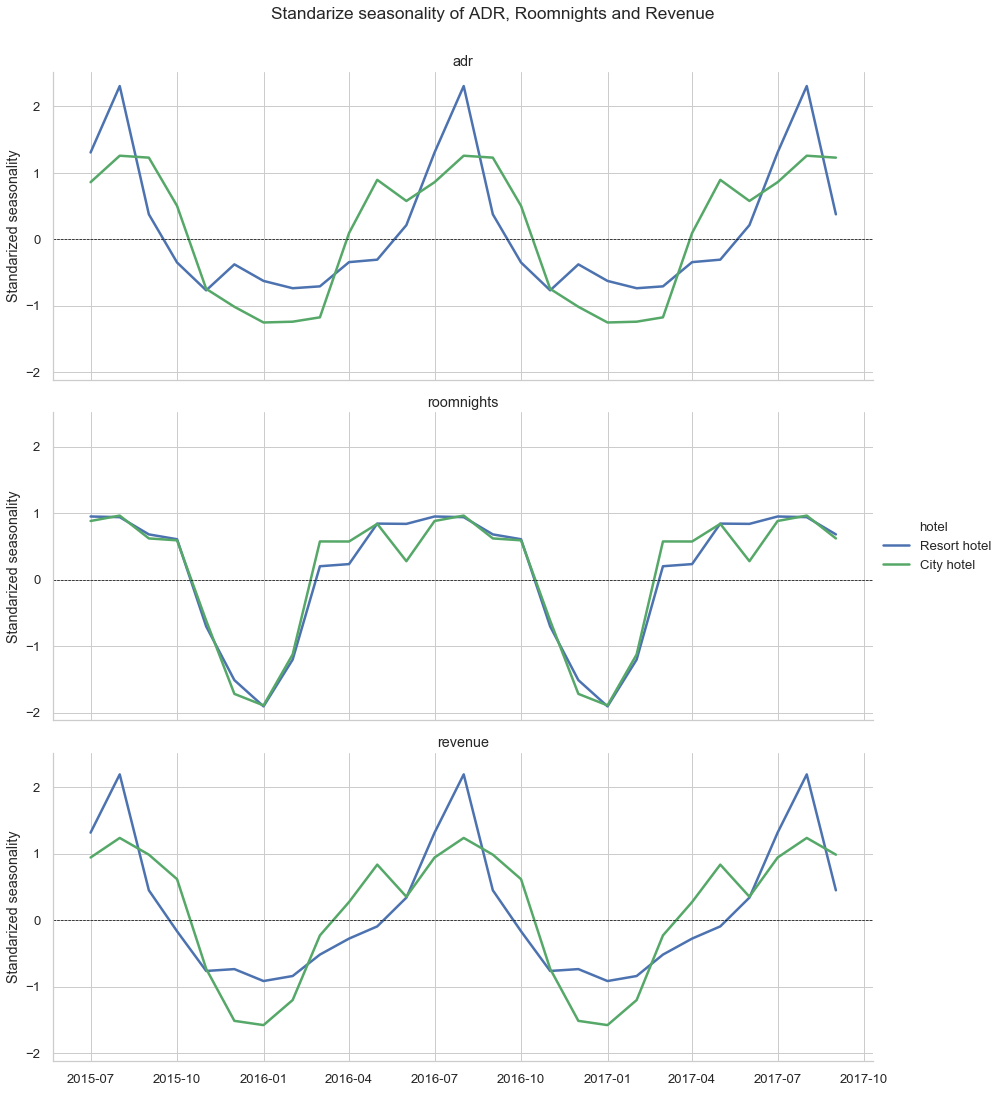

In [21]:
sns.set_context("notebook", font_scale = 1.2, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

g = sns.relplot(x = "stay_date", 
                y = "seas_standarized", 
                data = seas_df, 
                hue = "hotel", 
                col = "kpi",
                col_wrap = 1,
                kind = "line", 
                aspect = 2.5).set_titles("{col_name}").set_axis_labels("", "Standarized seasonality")

g.fig.suptitle("Standarize seasonality of ADR, Roomnights and Revenue", y = 1.03)


# titles = ["ADR", "Roomnights", "Revenue"]
for ax in range(len(g.axes)):
    g.axes[ax].axhline(0, color = "black", linestyle = "--", linewidth = 0.7)


##### Seasonality strength

. We'll compute the seasonality strenght as defined in[Forecasting: principles and practice](https://otexts.com/fpp2/seasonal-strength.htm) by Rob J Hyndman and George Athanasopoulos

$$F_S = max \left( 0, 1 - {{Var(R_t)} \over {Var(S_t + R_t)}}\right)$$



$F_s$ takes values from 0 to 1. The closer to 1 the strongest the seasonality component. $S_s$ is the seasonal component and $R_s$ is the residual component.

We see that there is a strong seasonality component in every kpi and hotel.

In [22]:
# print adr seasonality strength for both hotels
print("ADR resort seasonality: " + str(round(compute_seasonality_strength(dec_resort_adr), 3)))
print("ADR city seasonality: " + str(round(compute_seasonality_strength(dec_city_adr), 3)))

ADR resort seasonality: 0.993
ADR city seasonality: 0.944


In [23]:
# print roomnights seasonality strength for both hotels
print("Roomnights resort seasonality: " + str(round(compute_seasonality_strength(dec_resort_rn), 3)))
print("Roomnights city seasonality: " + str(round(compute_seasonality_strength(dec_city_rn), 3)))

Roomnights resort seasonality: 0.975
Roomnights city seasonality: 0.998


In [24]:
# print revenue seasonality strength for both hotels
print("Revenue resort seasonality: " + str(round(compute_seasonality_strength(dec_resort_rev), 3)))
print("Revenue city seasonality: " + str(round(compute_seasonality_strength(dec_city_rev), 3)))

Revenue resort seasonality: 0.999
Revenue city seasonality: 0.988


As we can see, weekly seasonality plays a huge role in defining the adr and the roomnights

##### Weekly seasonality

One can think that there is a second order in seasonality at the level of the weeks. For example, maybe more roomnights are booked for weekends

**Weekdays vs weekends**

In [25]:
# bookings_daily['stay_date'] = pd.to_datetime(bookings_daily['stay_date'])
bookings_daily = bookings_daily.reset_index()
bookings_daily['is_weekend'] = bookings_daily['stay_date'].apply(lambda x: x.weekday() in [5, 6])

In [26]:
bookings_daily

,stay_date,hotel,roomnights,revenue,adr,stay_month,stay_week,roomnights_m7,revenue_m7,adr_m7,is_weekend
0,2015-07-01,City Hotel,65,6180.00,95.076923,7,27,NaN,NaN,NaN,False
1,2015-07-01,Resort Hotel,36,3356.83,93.245278,7,27,NaN,NaN,NaN,False
2,2015-07-02,City Hotel,66,6238.67,94.525303,7,27,NaN,NaN,NaN,False
3,2015-07-02,Resort Hotel,64,6251.33,97.677031,7,27,NaN,NaN,NaN,False
4,2015-07-03,City Hotel,13,991.94,76.303077,7,27,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
1600,2017-09-09,Resort Hotel,7,946.52,135.217143,9,36,17.857143,2444.951429,138.724750,True
1601,2017-09-10,Resort Hotel,3,365.43,121.810000,9,36,17.285714,2365.924286,137.378831,True
1602,2017-09-11,Resort Hotel,3,365.43,121.810000,9,37,11.285714,1515.150000,134.714069,False
1603,2017-09-12,Resort Hotel,2,211.86,105.930000,9,37,11.000000,1454.167143,127.034784,False


In [27]:
bookings_daily_long = pd.melt(bookings_daily, 
                              id_vars = ['stay_date', 'hotel', 'is_weekend'], 
                              value_vars = ['adr', 'roomnights', 'revenue'], 
                              var_name = 'kpi'
                             )

Text(0.5, 1.03, 'Main KPIs distribution for weekdays and weekends')

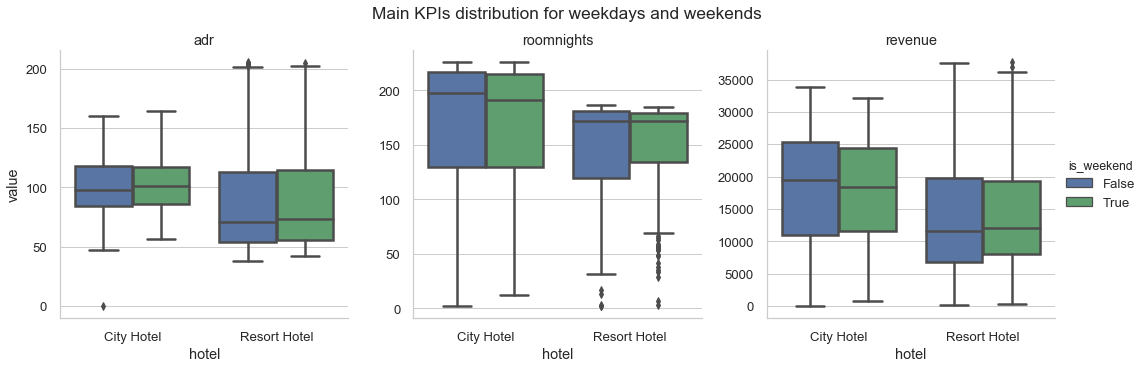

In [28]:
g = sns.catplot(x = "hotel", 
            y = "value", 
            data = bookings_daily_long, 
            hue = "is_weekend", 
            col = "kpi", 
            kind = "box", 
            sharey = False).set_titles("{col_name}")

g.fig.suptitle("Main KPIs distribution for weekdays and weekends", y = 1.03)


There seem to be no releveant differences in adr, roomnights or revenue

## 2. Does the behaviour of clients who come in groups differ from the behaviour of other clients in terms of stay days an lead time?

### Wrangling

Lets first create the binary variable "group" and then a stay day data frame to examine difference in roomnights for groups and non-groups

In [29]:
revenue_group = bookings_confirmed.groupby('group').agg({'revenue': 'sum'}) / bookings_confirmed.revenue.sum()

### EDA

In [30]:
bookings_confirmed.customer_type.value_counts()

Transient          53099
Transient-Party    18735
Contract            2814
Group                518
Name: customer_type, dtype: int64

There are only 518 reservations assigned to groups. So groups don't represent a highly relevant business segment, right from the start. 

In [31]:
revenue_group

,revenue
group,
False,0.995255
True,0.004745


Groups represent only the 5 % of the total revenue. Anyways, is good to perform an analysis of this segment in case its relative importance increases in the future.

#### Average length of stay

In [32]:
bookings_confirmed.groupby(['hotel', 'group']).agg({'length_of_stay':['mean', 'median', 'std']})

length_of_stay                 
                             mean median       std
hotel        group                                
City Hotel   False       2.925289      3  1.762338
             True        2.632576      3  1.714798
Resort Hotel False       4.153430      3  3.375581
             True        2.952756      2  2.965835

Median length of stay is lower for groups in Resort hotels, lets check out the distribution for the grouped version of the length of stay variable: los_int

In [33]:
# counts occurcences grouped by group hotel and los_int
los_int_group_hotel = bookings_confirmed.groupby(['los_int', 'group', 'hotel']).agg({'is_canceled': 'count'})\
.rename(columns = {'is_canceled': 'n'})

# computes relative frequencies
los_int_group_hotel['f'] = los_int_group_hotel.groupby(['group', 'hotel'])['n'].apply(lambda x: x / sum(x))
los_int_group_hotel.reset_index(inplace = True)
los_int_group_hotel.sort_values(['hotel', 'group'], inplace = True)

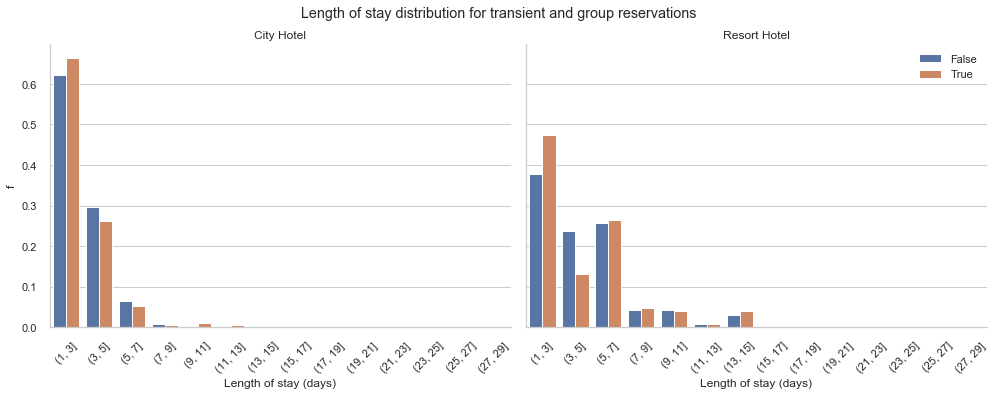

In [34]:
sns.set(style = "whitegrid")
g = sns.catplot(x = 'los_int', 
                y ='f', 
                data = los_int_group_hotel, 
                kind = "bar", 
                hue = 'group',
                col = 'hotel', 
                legend = False, 
                aspect = 1.4).set_titles("{col_name}")

plt.legend(loc=1)

g.fig.suptitle("Length of stay distribution for transient and group reservations", y = 1.03)
g.set_xticklabels(rotation=45)

g.axes[0,0].set_xlabel('Length of stay (days)')
g.axes[0,1].set_xlabel('Length of stay (days)')

plt.show()

The descriptive statistics shows a difference only in one day in the median length of stay for resot hotels. The bar chart reveals a higher frequency of short stays of 1 - 3 days for groups and a lower frequency in longer stays (3 - 5 days), in resort hotels. 

#### Lead time

In [35]:
bookings_confirmed.groupby(['hotel', 'group']).agg({'lead_time': 'mean'})

lead_time
hotel        group           
City Hotel   False  80.855104
             True   54.174242
Resort Hotel False  79.224969
             True   35.094488

Text(0.5, 8.960000000000008, 'Is group')

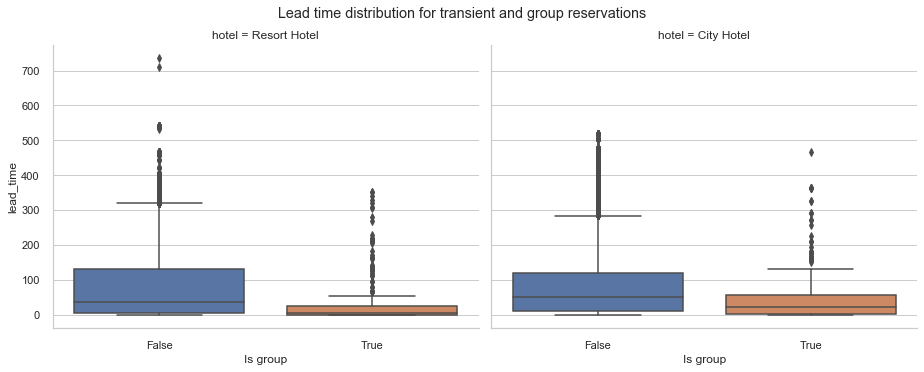

In [36]:
sns.set(style = "whitegrid")
g = sns.catplot(x = "group", 
            y = "lead_time", 
            data = bookings_confirmed, 
            kind = "box", 
            col = "hotel", 
            aspect = 1.3)

# plt.legend(loc=1)

g.fig.suptitle("Lead time distribution for transient and group reservations", y = 1.03)


g.axes[0,0].set_xlabel('Is group')
g.axes[0,1].set_xlabel('Is group')


Groups seem bo book with less antelation that transient, specially in the resort hotel. Let's test that


#### ADR

In [37]:
bookings_confirmed.groupby(['hotel', 'group']).agg({'adr': 'mean'})

adr
hotel        group            
City Hotel   False  105.851328
             True    87.398712
Resort Hotel False   90.908359
             True    77.306575

Text(0.5, 8.960000000000008, 'Is group')

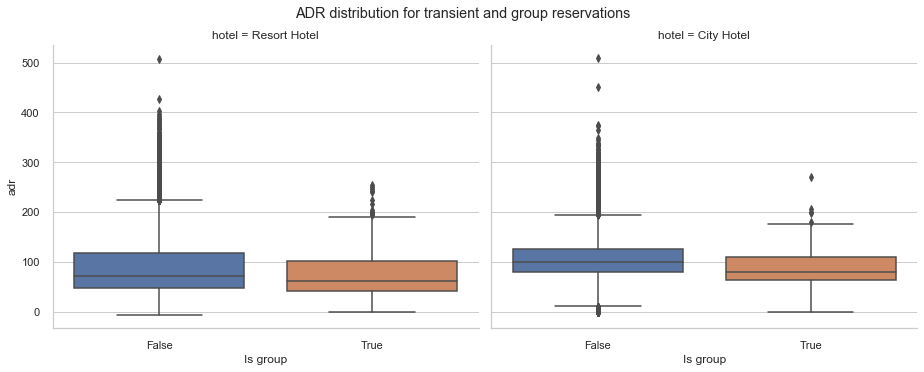

In [38]:
g = sns.catplot(x = "group", 
                y = "adr", 
                data = bookings_confirmed, 
                kind = "box", 
                col = "hotel", 
                aspect = 1.3)

g.fig.suptitle("ADR distribution for transient and group reservations", y = 1.03)


g.axes[0,0].set_xlabel('Is group')
g.axes[0,1].set_xlabel('Is group')

### Modeling

#### Testing differences in aveage length 

We'll now test if there is any difference in l.o.s ussing the Mann-Whitney non-parametric U test, since the distribution is extremely assymetric.

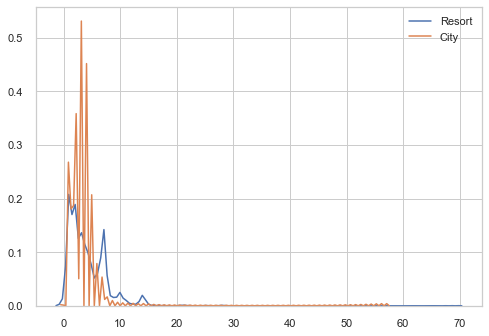

In [39]:
sns.kdeplot(resort_confirmed['length_of_stay'], label = "Resort")
sns.kdeplot(city_confirmed['length_of_stay'], label = "City")
plt.show()

###### Resort hotel

In [40]:
los_resort_transient = resort_confirmed[~resort_confirmed.group]["length_of_stay"] 
los_resort_group = resort_confirmed[resort_confirmed.group]["length_of_stay"] 

In [41]:
mannwhitneyu(los_resort_transient, los_resort_group)

MannwhitneyuResult(statistic=2612912.0, pvalue=1.885162483678844e-15)

###### City hotel

In [42]:
los_city_transient = resort_confirmed[~city_confirmed.group]["length_of_stay"] 
los_city_group = resort_confirmed[city_confirmed.group]["length_of_stay"] 

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [43]:
mannwhitneyu(los_city_transient, los_city_group)

MannwhitneyuResult(statistic=2335711.0, pvalue=0.00015788001921330537)

Though results show statistically significant differnces in both cases, the effect size is almost non existent for the city hotel. And is not very large for the resort hotel (at most, one day in average), so has only probably limited relevance from the bussiness standpoint.

The business difference can be important if there are differences in for of five days. For instance, transient bookings with a length of stay of 7 days vs groups with a lentgh of stay of 2 or 3 days.

#### Testing differences in lead time

We have again a very assymetric distribution. Well proceed with the Mann-Whitney U test

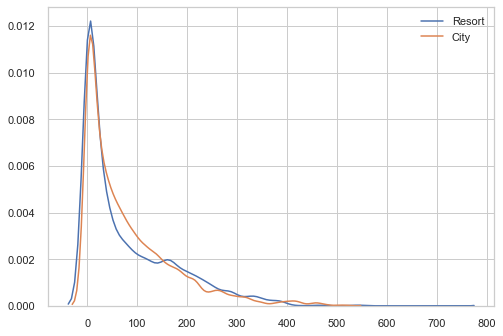

In [44]:
sns.kdeplot(resort_confirmed['lead_time'], label = "Resort")
sns.kdeplot(city_confirmed['lead_time'], label = "City")

###### Resort

In [45]:
lead_resort_transient = resort_confirmed[~resort_confirmed.group]["lead_time"] 
lead_resort_group = resort_confirmed[resort_confirmed.group]["lead_time"] 

In [46]:
mannwhitneyu(lead_resort_transient, lead_resort_group)

MannwhitneyuResult(statistic=2245682.0, pvalue=2.5896585105512173e-26)

###### City

In [47]:
lead_city_transient = city_confirmed[~city_confirmed.group]["lead_time"] 
lead_city_group = city_confirmed[city_confirmed.group]["lead_time"] 

In [48]:
mannwhitneyu(lead_city_transient, lead_city_group)

MannwhitneyuResult(statistic=4637570.0, pvalue=1.8762541555852268e-11)

In both cases there is a significant effect, and the size of the effect is considerable.

There seems to bedifferences in adr. Specially for the city hotel

#### Testing differences in adr

Since in this case, the dsitribution is not extremely symmetrical, we'll proceed with the t-test for the comparisons

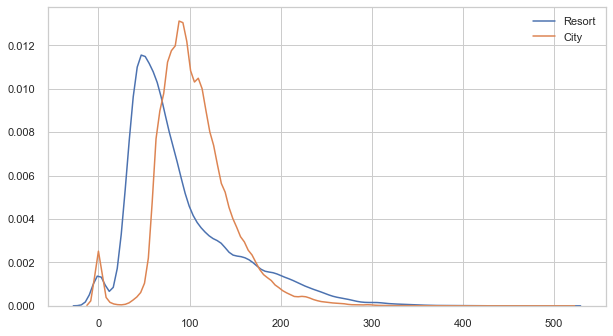

In [49]:
fig, ax = plt.subplots()

sns.kdeplot(resort_confirmed['adr'], ax = ax, label = "Resort")
sns.kdeplot(city_confirmed['adr'], ax = ax, label = "City")

fig.set_figwidth(10)

##### Resort

In [50]:
# test for resort hotels
ttest_ind(resort_confirmed.loc[resort_confirmed.group == False, "adr"], 
          resort_confirmed.loc[resort_confirmed.group == True, "adr"])

Ttest_indResult(statistic=3.639007722339967, pvalue=0.00027416670642179514)

##### City

In [51]:
# test for resort hotels
ttest_ind(city_confirmed.loc[city_confirmed.group == False, "adr"], 
          city_confirmed.loc[city_confirmed.group == True, "adr"])

Ttest_indResult(statistic=7.368550321326325, pvalue=1.7536548791587397e-13)

Significant results with a considerable effect size for both city and resort hotel

# CALCULAR ADR EN FUNCIÓN DE LEAD TIME!

In [53]:
bookings_confirmed.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'length_of_stay', 'los_int', 'departure_date', 'booking_date',
       'booking_month', 'revenue', 'lead_time_weeks', 'weekday_checkin',
       'weekday_checkout', 'group'],
      dtype='object')

Given this results, though right now grouped bookings doesn't seem to be an important segment. After analyzing adr and lead time, one thing that could be happening is that hoteliers are having difficulties in filling up the hotel (unfortunatelly hotel capacity is not among the variables in the dataset).  

If that is not the case, it would be advisable to reconsider rate policies regarding groups and build an strategy for gorup pricing.

## 3. Can we predict if a client will cancel the reservation, just with the information available at the moment this reservation has been made?

In this section, we'll try to predict if a booking reservation is going to be cancelled in the future, using variables available only when the reservation is made. That means that we can't make use of the variable 'booking_changes' for instance.

Our target variable is 'is_canceled' and we'll train an algorith splitting the bookings DataFrame.

First, we'll perform an **exploratory analysis**. Most of it will consisnt in facing is_cancelled against the other variables. A big share of these variables are categorical. It is important not only stablish the relationship of these categories with the target variable, but also checking if there are enough observations from potential categories of interest. For that reason we've create the function **plot_cancel_prop** to automatize this process. The function besides of displaying a plot showing the relationship between the target variable and the respective covariate, shows a table counting the percentage of observations for each category.

**New features we'll be created in the EDA process itself** whenever it's considered convenient according to the findings during the process.

We'll split most of the visualization into Resort hotel and City hotel, as the different business nature of the two, can lead to a potential different behaviour in the number of cancelations

In [52]:
bookings.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'length_of_stay', 'los_int', 'departure_date', 'booking_date',
       'booking_month', 'revenue', 'lead_time_weeks', 'weekday_checkin',
       'weekday_checkout', 'group'],
      dtype='object')

### EDA

Proportion of bookings cancelled. Overall and for hotel type

In [53]:
bookings.is_canceled.mean()

0.37041628277075134

In [54]:
bookings.groupby("hotel")['is_canceled'].mean()

hotel
City Hotel      0.417270
Resort Hotel    0.277634
Name: is_canceled, dtype: float64

Now we'll confront each potential covariate of the model with the target variable

#### Is repeated guest 

(0    0.968088
 1    0.031912
 Name: is_repeated_guest, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfb81ca608>)

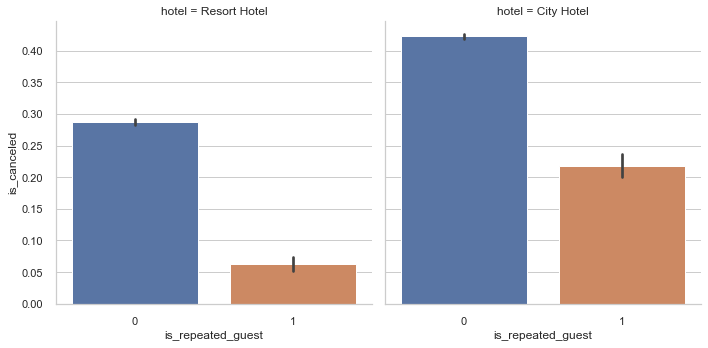

In [55]:
plot_cancel_prop(bookings, "is_repeated_guest")

People who cancel are overrepresented in new guests.

It isn't a variable of much value since almost every guest is a new guest

#### Previous cancelations

In [56]:
bookings.previous_cancellations.value_counts()

0     112906
1       6051
2        116
3         65
24        48
11        35
4         31
26        26
25        25
6         22
19        19
5         19
14        14
13        12
21         1
Name: previous_cancellations, dtype: int64

In [57]:
np.mean(bookings.previous_cancellations > 0)

0.054309406147918585

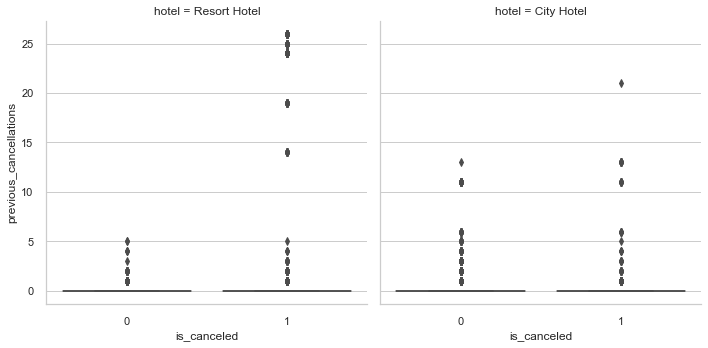

In [58]:
sns.catplot(x = "is_canceled", y = "previous_cancellations", data = bookings, kind = "box", col = "hotel")

It seems it can be a relationship but the variable is too assymetrical. We'll create the variable 'has_previous_cancelations' and analyse the relationship for this variable.

In [59]:
bookings['has_previous_cancellations'] = bookings.previous_cancellations > 0

(False    0.945691
 True     0.054309
 Name: has_previous_cancellations, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfc132c8c8>)

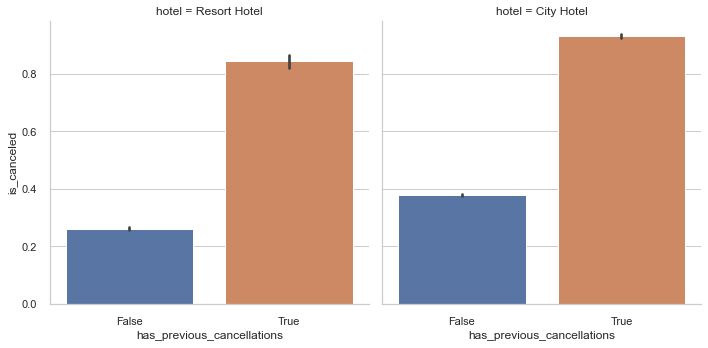

In [60]:
plot_cancel_prop(bookings, "has_previous_cancellations")

It looks like people who have cancel previously tend to cancel a lot more. But these people amount for only a 5 % of the total number of bookings

#### Reserved room type 

(A    0.720278
 D    0.160826
 E    0.054737
 F    0.024265
 G    0.017539
 B    0.009364
 C    0.007806
 H    0.005034
 P    0.000101
 L    0.000050
 Name: reserved_room_type, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfc9a1fd08>)

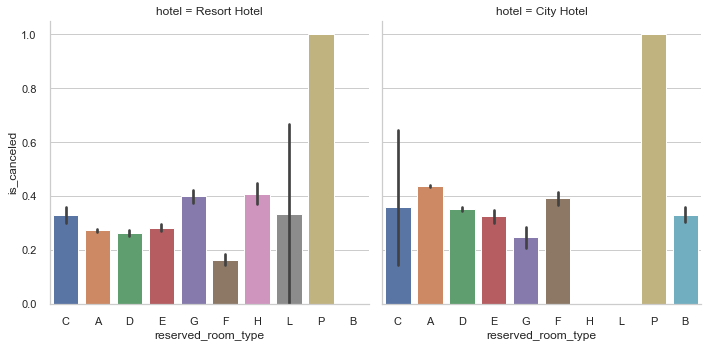

In [61]:
plot_cancel_prop(bookings, "reserved_room_type")

In [62]:
bookings[bookings.reserved_room_type == "P"]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,los_int,departure_date,booking_date,booking_month,revenue,lead_time_weeks,weekday_checkin,weekday_checkout,group,has_previous_cancellations
4127,Resort Hotel,1,0,2016,February,8,15,0,0,0,...,NaN,2016-02-15,2016-02-15,Feb,0.0,0,0,0,False,False
9376,Resort Hotel,1,0,2016,November,48,21,0,0,0,...,NaN,2016-11-21,2016-11-21,Nov,0.0,0,0,0,True,False
60651,City Hotel,1,0,2016,November,47,17,4,11,0,...,"(13.0, 15.0]",2016-12-02,2016-11-17,Nov,0.0,0,3,4,False,False
61244,City Hotel,1,0,2016,December,50,6,0,0,0,...,NaN,2016-12-06,2016-12-06,Dec,0.0,0,1,1,False,False
61245,City Hotel,1,0,2016,December,50,6,0,0,0,...,NaN,2016-12-06,2016-12-06,Dec,0.0,0,1,1,False,False
61249,City Hotel,1,0,2016,December,50,6,0,0,0,...,NaN,2016-12-06,2016-12-06,Dec,0.0,0,1,1,False,False
65907,City Hotel,1,0,2017,April,15,10,0,0,0,...,NaN,2017-04-10,2017-04-10,Apr,0.0,0,0,0,False,False
65908,City Hotel,1,0,2017,April,15,10,0,0,0,...,NaN,2017-04-10,2017-04-10,Apr,0.0,0,0,0,False,False
65909,City Hotel,1,0,2017,April,15,10,0,0,0,...,NaN,2017-04-10,2017-04-10,Apr,0.0,0,0,0,False,False
65910,City Hotel,1,0,2017,April,15,10,0,0,0,...,NaN,2017-04-10,2017-04-10,Apr,0.0,0,0,0,False,False


We must remove these values. The P rooms are likely tests or something like that. Revenue for everyone of these is 0. Lead time is also 0

In [63]:
bookings = bookings[bookings.reserved_room_type != "P"]

From the rooms that are booked the most, the one with more cancelations in City Hotels is room A. There doesn't seem to be a lot of difference though.

#### Lead time

Lets compute proportion of cancelations by lead_time_weeks and plot the weeks to go against the proportion of booking cancellations.

In [64]:
cancel_lead_time = bookings.groupby(['hotel', 'lead_time_weeks']).agg({'is_canceled': 'mean'}).reset_index()

In [65]:
cancel_lead_time.head()

,hotel,lead_time_weeks,is_canceled
0,City Hotel,0,0.118725
1,City Hotel,1,0.234020
2,City Hotel,2,0.296690
3,City Hotel,3,0.357527
4,City Hotel,4,0.391850


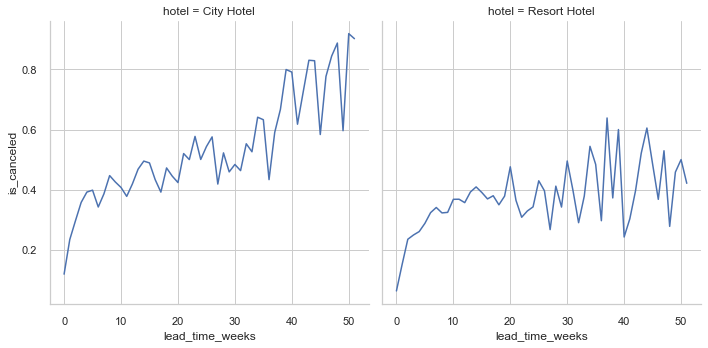

In [66]:
sns.relplot(x = "lead_time_weeks", y = "is_canceled", 
            data = cancel_lead_time[cancel_lead_time.lead_time_weeks < 52] , col = "hotel", col_wrap = 2, kind = "line");

Positive relationship between cancelations and lead time in city hotels, not as clear in resort hotels. Nevertherles, in both cases there are few cancelations in reservations with little antelation.

#### Deposit type

(No Deposit    0.876451
 Non Refund    0.122192
 Refundable    0.001357
 Name: deposit_type, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfb9a58c08>)

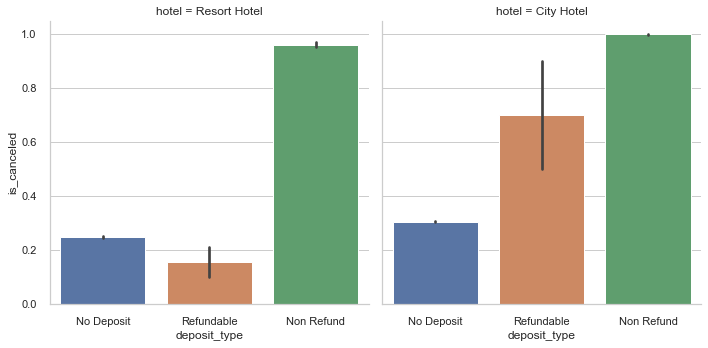

In [67]:
plot_cancel_prop(bookings, "deposit_type")

Non refundable rate reservations cancel a lot more. Maybe they are related with some offer like an early booking. Let's check average adr for these categories

In [68]:
bookings.groupby(['hotel', 'deposit_type'])['adr'].mean()

hotel         deposit_type
City Hotel    No Deposit      107.674593
              Non Refund       93.135309
              Refundable      114.977500
Resort Hotel  No Deposit       96.340759
              Non Refund       66.224532
              Refundable       70.749507
Name: adr, dtype: float64

Yes, it looks like Non Refundable tarifs have lower adr

#### Agent

Let's look at the distribution first

In [69]:
agent_distrib = (bookings.agent.value_counts().sort_values(ascending = False) / sum(bookings.agent.value_counts()))
agent_distrib.head(10)

9.0      0.310150
240.0    0.135099
1.0      0.069782
14.0     0.035323
7.0      0.034343
6.0      0.031926
250.0    0.027851
241.0    0.016701
28.0     0.016167
8.0      0.014692
Name: agent, dtype: float64

To many agents. Lets group them into the more important ones. The seventh' agent only has approx 3 % of the market. We'll group agents into the top 6.

In [70]:
bookings['agent_grouped'] = group_main_categories(bookings, "agent", 6)

C:\Users\marti\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(other    0.467716
 9.0      0.267729
 240.0    0.116621
 1.0      0.060237
 14.0     0.030491
 7.0      0.029645
 6.0      0.027560
 Name: agent_grouped, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bf99bfed88>)

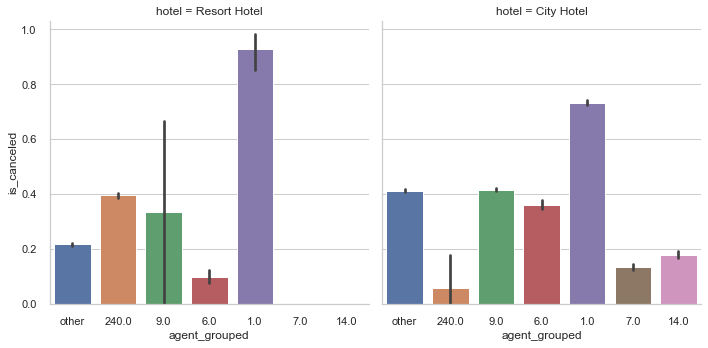

In [71]:
plot_cancel_prop(bookings, 'agent_grouped')

Agent one gets a lot of cancelattions

#### Company

Again, a lot of categories, let's group them. 40 and 223 domain the market for these hotels

In [72]:
sort_categories_distrib(bookings, "company").head(10)

,f,F
40.0,0.136585,0.136585
223.0,0.115515,0.252100
67.0,0.039340,0.291440
45.0,0.036835,0.328275
153.0,0.031678,0.359953
174.0,0.021954,0.381907
219.0,0.020775,0.402682
281.0,0.020333,0.423015
154.0,0.019596,0.442611
405.0,0.017534,0.460144


In [73]:
bookings['company_grouped'] = group_main_categories(bookings, 'company', 6)

C:\Users\marti\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(other    0.978287
 40.0     0.007765
 223.0    0.006567
 67.0     0.002237
 45.0     0.002094
 153.0    0.001801
 174.0    0.001248
 Name: company_grouped, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfad0e8308>)

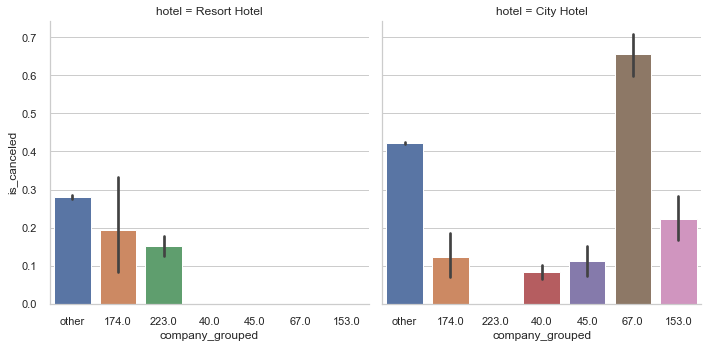

In [74]:
plot_cancel_prop(bookings, "company_grouped")

It turns out that 223 operates in resort hotels and 40 in city hotels. Both of them have a number of cancellations below the average for these hotels.

City hotels has a lot of cancelations for the company 67.

#### Children 

Lot of guests travel without children

In [75]:
bookings.children.value_counts()

0.0     110784
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

This happens both in city and resort hotels

In [76]:
bookings.groupby(["hotel", "children"])['hotel'].count()

hotel         children
City Hotel    0.0         74210
              1.0          3023
              2.0          2024
              3.0            59
Resort Hotel  0.0         36574
              1.0          1838
              2.0          1628
              3.0            17
              10.0            1
Name: hotel, dtype: int64

(0.0     0.928041
 1.0     0.040721
 2.0     0.030593
 3.0     0.000637
 10.0    0.000008
 Name: children, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfb0786508>)

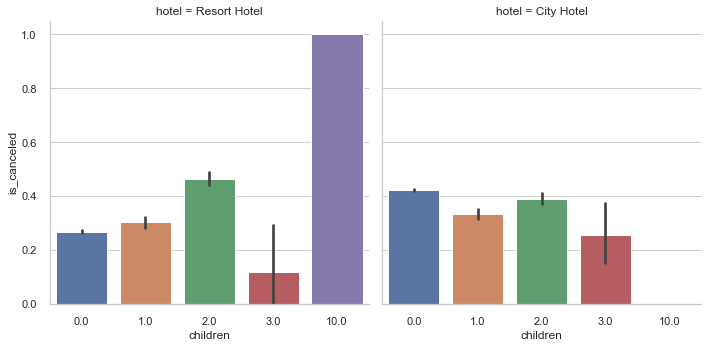

In [77]:
plot_cancel_prop(bookings, "children")

It looks like having more than one children involves having a greater cancelation rate than the average. Again, people with children seem to be a minority here.

#### Adults

In [78]:
bookings.adults.value_counts()

2     89680
1     23027
3      6202
0       391
4        62
26        5
27        2
20        2
5         2
55        1
50        1
40        1
10        1
6         1
Name: adults, dtype: int64

The more normal travel mode is 'couple'. There are a few reservations with no adults.

(2    0.751718
 1    0.193018
 3    0.051987
 0    0.003277
 Name: adults, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfa5b82788>)

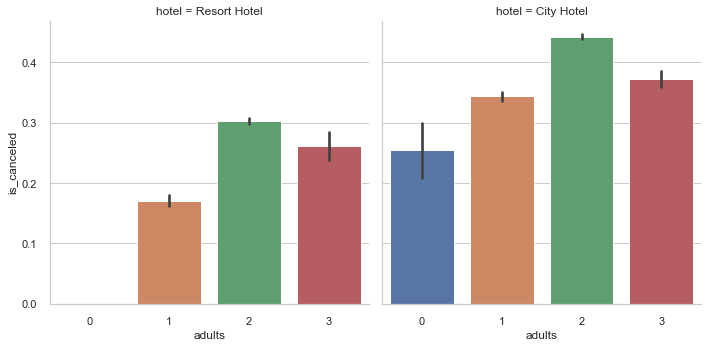

In [79]:
plot_cancel_prop(bookings[bookings.adults < 4], "adults")

It looks like people who travel alone tend to cancel less. In resort hotels, rate of cancellation for couples is above the mean. We'll create a new feature to reflect that.

In [80]:
bookings['travels_alone'] = bookings['adults'] <= 1

C:\Users\marti\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Meal

(BB           0.773258
 HB           0.121153
 SC           0.089112
 Undefined    0.009792
 FB           0.006685
 Name: meal, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfb15e4f48>)

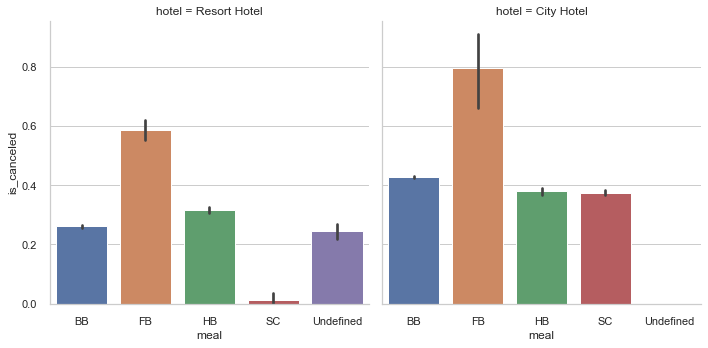

In [81]:
plot_cancel_prop(bookings, "meal")

Cancellations for Full Board are well above the average, but then again, the number of customer who chose this type of meal is very minimal (0.7 %).

#### country 

In [82]:
len(bookings.country.unique())

178

Two many categories for countries. Let's see what are the country of origin with more reservations

In [83]:
sort_categories_distrib(bookings, "country").head(10)

,f,F
PRT,0.408646,0.408646
GBR,0.102010,0.510656
FRA,0.087595,0.598251
ESP,0.072061,0.670311
DEU,0.061287,0.731598
ITA,0.031674,0.763272
IRL,0.028385,0.791657
BEL,0.019697,0.811354
BRA,0.018705,0.830059
NLD,0.017696,0.847754


With the first 7 countries we reach a 70 % of the reservations

In [84]:
bookings['country_grouped'] = group_main_categories(bookings, "country", 7)

C:\Users\marti\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(PRT      0.407010
 other    0.211513
 GBR      0.101602
 FRA      0.087244
 ESP      0.071772
 DEU      0.061041
 ITA      0.031547
 IRL      0.028272
 Name: country_grouped, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfb1fedf88>)

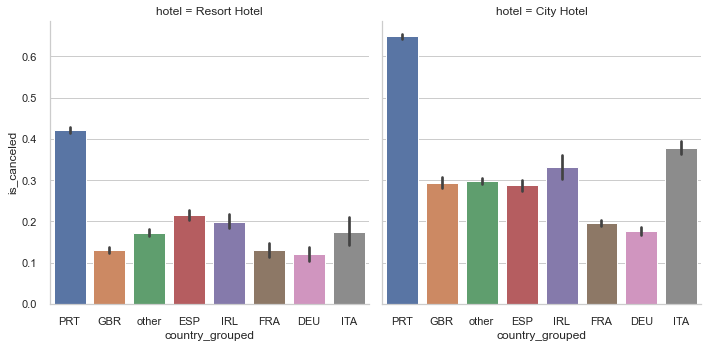

In [85]:
plot_cancel_prop(bookings, 'country_grouped')

Portuguese tend to cancel well above the average. Plus, they are an important market.

We built variable market origin local to represent the fact that locals are the ones we have to put our eyes on

In [86]:
bookings['market_origin_local'] = bookings['country'] == "PRT"

C:\Users\marti\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Market segment 

(Online TA        0.473077
 Offline TA/TO    0.202860
 Groups           0.165952
 Direct           0.105597
 Corporate        0.044347
 Complementary    0.006165
 Aviation         0.001985
 Undefined        0.000017
 Name: market_segment, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfa6b4ddc8>)

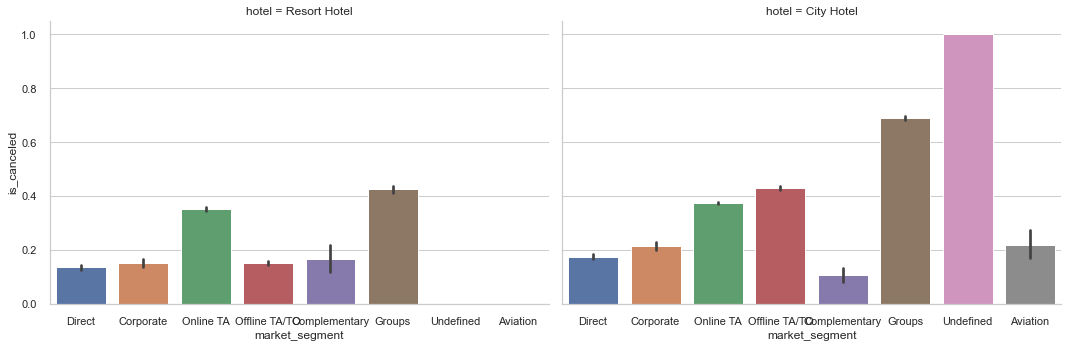

In [87]:
plot_cancel_prop(bookings, "market_segment", aspect = 1.5)

Groups and onlne TA tend to cancel above the average in resort hotels. In hotels, also groups, but unidentified segment too, tend to canel more

#### distribution channel

(TA/TO        0.819799
 Direct       0.122669
 Corporate    0.055873
 GDS          0.001617
 Undefined    0.000042
 Name: distribution_channel, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfa6b531c8>)

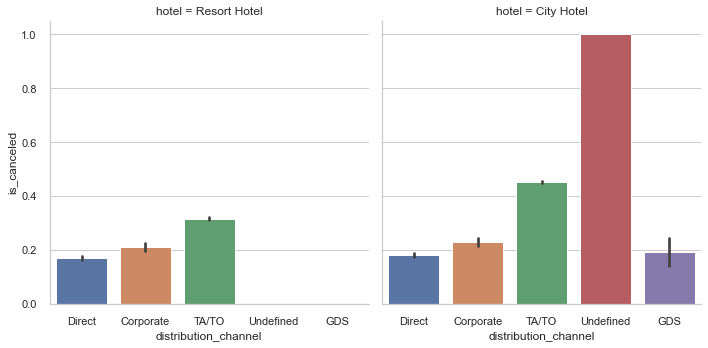

In [88]:
plot_cancel_prop(bookings, "distribution_channel")

TA and undefined (for city hotels) tend to cancel Above the mean

#### days in waiting list 

In [89]:
bookings.days_in_waiting_list.value_counts()


0      115680
39        227
58        164
44        141
31        127
        ...  
175         1
117         1
89          1
92          1
183         1
Name: days_in_waiting_list, Length: 128, dtype: int64

Too many values and outliers for days_in_waiting_list. Let's check which are the most common.

In [90]:
sort_categories_distrib(bookings, "days_in_waiting_list").head(10)

,f,F
0,0.969023,0.969023
39,0.001902,0.970924
58,0.001374,0.972298
44,0.001181,0.973479
31,0.001064,0.974543
35,0.000804,0.975347
46,0.000787,0.976135
69,0.000746,0.976880
63,0.000695,0.977575
50,0.000670,0.978246


Most people don't wait: we'll create the variable 'in_waiting_list' to analyze the relationship of being waiting list with the target variable.

In [91]:
bookings['in_waiting_list'] = bookings['days_in_waiting_list'].apply(lambda x: x > 0)

C:\Users\marti\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(False    0.969023
 True     0.030977
 Name: in_waiting_list, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfa5b03508>)

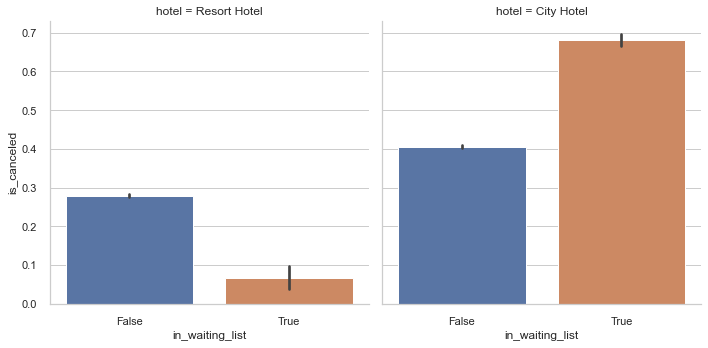

In [92]:
plot_cancel_prop(bookings, "in_waiting_list")

Inverse relationship for resort hotels and city hotels: in city hotels people who are in waiting list tend to cancel way above the mean, whereas in resort hotels, the opposite is true.

#### Customer type

(Transient          0.750574
 Transient-Party    0.210458
 Contract           0.034144
 Group              0.004825
 Name: customer_type, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfb1a64948>)

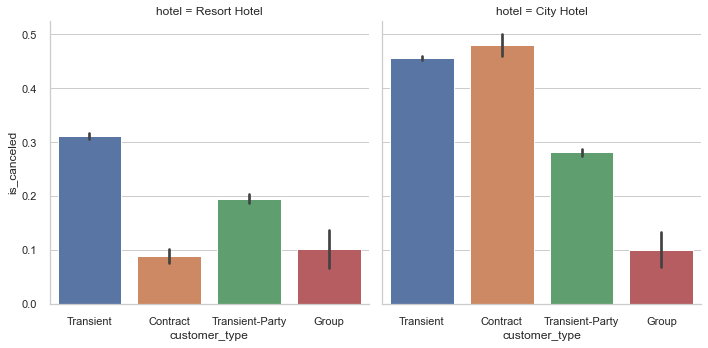

In [93]:
plot_cancel_prop(bookings, "customer_type")

Transient cancel a little above the mean for resort hotels

#### Required car parking spaces

(0    0.937878
 1    0.061846
 2    0.000235
 3    0.000025
 8    0.000017
 Name: required_car_parking_spaces, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfa7d412c8>)

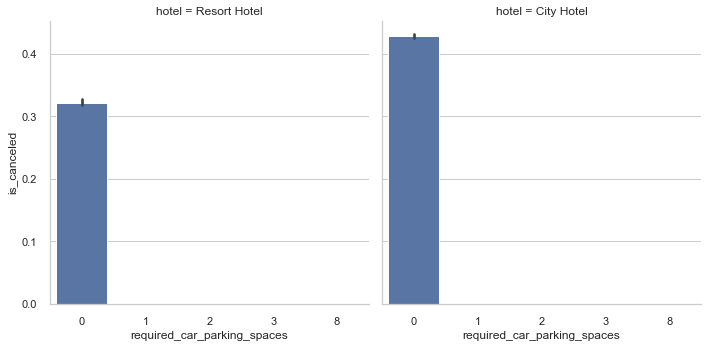

In [94]:
plot_cancel_prop(bookings, "required_car_parking_spaces")

Variable with almos no variability. Useless in predictions

#### Total of special requests

(0    0.588936
 1    0.278326
 2    0.108638
 3    0.020917
 4    0.002848
 5    0.000335
 Name: total_of_special_requests, dtype: float64,
 <seaborn.axisgrid.FacetGrid at 0x1bfa7d40c48>)

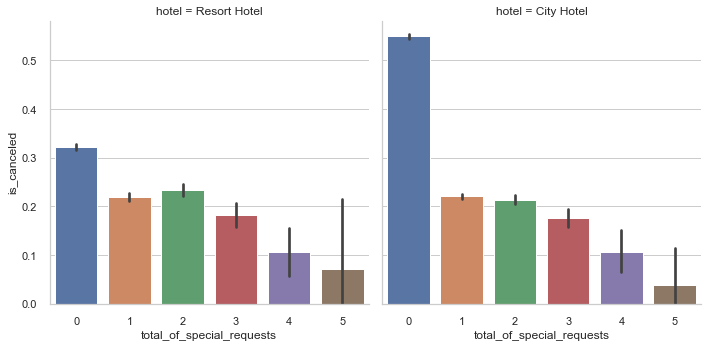

In [95]:
plot_cancel_prop(bookings, "total_of_special_requests")

People who have spetial requests tend to cancel below the average, and it looks like the more spetial guests, the less liklehood for a cancellation.

#### ADR 

C:\Users\marti\anaconda3\lib\site-packages\seaborn\axisgrid.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)


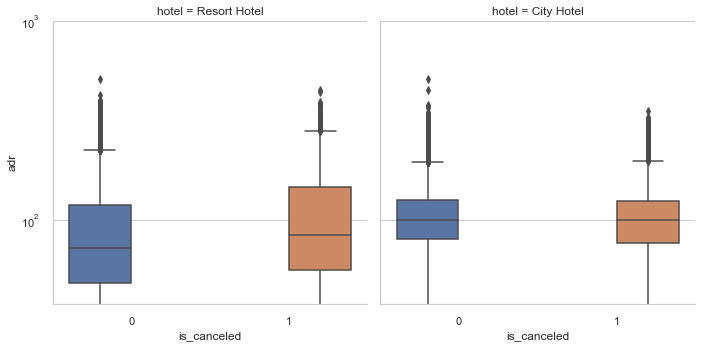

In [96]:
# fig, ax = plt.subplots()
g = sns.catplot(x = "is_canceled", y = "adr", data = bookings, kind = "box", hue = "is_canceled", col = "hotel")
g.set(yscale="log", ylim = (0, 1000))


For people in resorts bookings canceled tend to have higher ADR. Maybe there is a difference in resort

#### Summary of findings

Cancelation percentage over bookings is 37 %. 27 % for the resort hotel and 41 % for the city hotel

Variables with more predictive potential based on the exploratory analysis

- **hotel**: In the resort hotel 27 % of reservation are canceled while the city hotel is 41 %.

- **is_repeated_guest**: Very few cancelations for repeated guests though only 3 % of guests repeat.

- **has_previous_cancellations**: reservations with previous cancelations tend to cancel more but they represent only a 5 % of total bookinggs.

- **deposit_type**: High levels con cancellations for non-refundable bookings. Which amount for 12 % of bookings.

- **lead_time_weeks**: there is a clear positive relationship between proportion of bookings canceled and lead time.

- **agent_grouped**: there are some agents whose reservations are clearly above average.

- **company_grouped**: Bookings for the two main companies are canceled below the average.

- **children**: people with children tend to cancel more than the average (though they only represent a 3 % of the bookings).

- **adults**: people who travel alone tend to cancel less (19 % of the bookings fall into this group).

- **country_grouped**: Portuguese (local market) tend to cancel a lot more, and they are the most abundant (40 % of the reservations).

- **market_segment**: online TA in resort and groups en city tend to cancel more.

- **customer_type**: among the important categories, Groups and transient-party tend to cancel less than the average.

- **total_spetial_requests**: people who have spetial requests tend to cancel below the average, specially in the city hotel.

- **adr**: it looks like it could have an influence in resort hotels.

For interpretability reasons, since there could be multicolinearity between adr and other variables like deposit type, we'll not use it in our model.

### Modeling

**Pick variables for modeling**

In [97]:
df_model = bookings[['is_canceled', 'hotel', 'market_origin_local', 'total_of_special_requests', 
                     'lead_time_weeks', 'deposit_type', 'travels_alone', 'agent_grouped', 'is_repeated_guest', 
                     'has_previous_cancellations', 'children', 'market_segment', 
                     'customer_type', 'company_grouped', 'arrival_date_month', 'arrival_date_month', 'booking_month']]

**Filling na values**

Agent is the only variable with missing values. We'll proceed to flag this values with the name 'missing'

In [98]:
# df_model['agent'] = df_model['agent'].fillna('missing')
df_model['children'] = df_model['children'].fillna('missing')

C:\Users\marti\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Model matrices and creation of dummy variables**

In [99]:
# extracting the response variable and assigning it to the y array
df_response = df_model.drop('is_canceled', axis = 1)
y = df_model['is_canceled']

# getting dummies and assign the data to the X array
X = pd.get_dummies(df_response)

#### Data split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 123)

#### Model selection

We confronted logistic regression with a random forest classifier, giving the latter systemmatically better results than the former.

We include here the model selection for the random forest classifier

In [101]:
# creation of Random Forest classifier
rf = RandomForestClassifier(random_state = 123, oob_score = True)

# hyperparameters
params_rf = {'n_estimators': [100, 250, 500], 
             'max_features': ['log2', 'auto', 'sqrt']}

# Cross validation with grid search
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, verbose = 1, n_jobs = 2)

In [102]:
# model fitting
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed: 12.3min finished


GridSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=123),
             n_jobs=2,
             param_grid={'max_features': ['log2', 'auto', 'sqrt'],
                         'n_estimators': [100, 250, 500]},
             verbose=1)

In [103]:
# getting best model and OOB cv score
best_model = grid_rf.best_estimator_
best_model.oob_score_

0.8496601407304581

In [104]:
best_model

RandomForestClassifier(n_estimators=250, oob_score=True, random_state=123)

#### Best model fitting on entire training set

In [105]:
best_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, oob_score=True, random_state=123)

#### Model prediction

In [106]:
y_pred_rf = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]

#### Model evaluation

In [107]:
roc_auc_score(y_test, y_pred_proba)

0.9199612988478018

In [108]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[20235  2328]
 [ 3080 10171]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88     22563
           1       0.81      0.77      0.79     13251

    accuracy                           0.85     35814
   macro avg       0.84      0.83      0.84     35814
weighted avg       0.85      0.85      0.85     35814



The model has an accuracy of 0.85, a recall of 0.77, and an f1 score of 0.79

##### Feature importance 

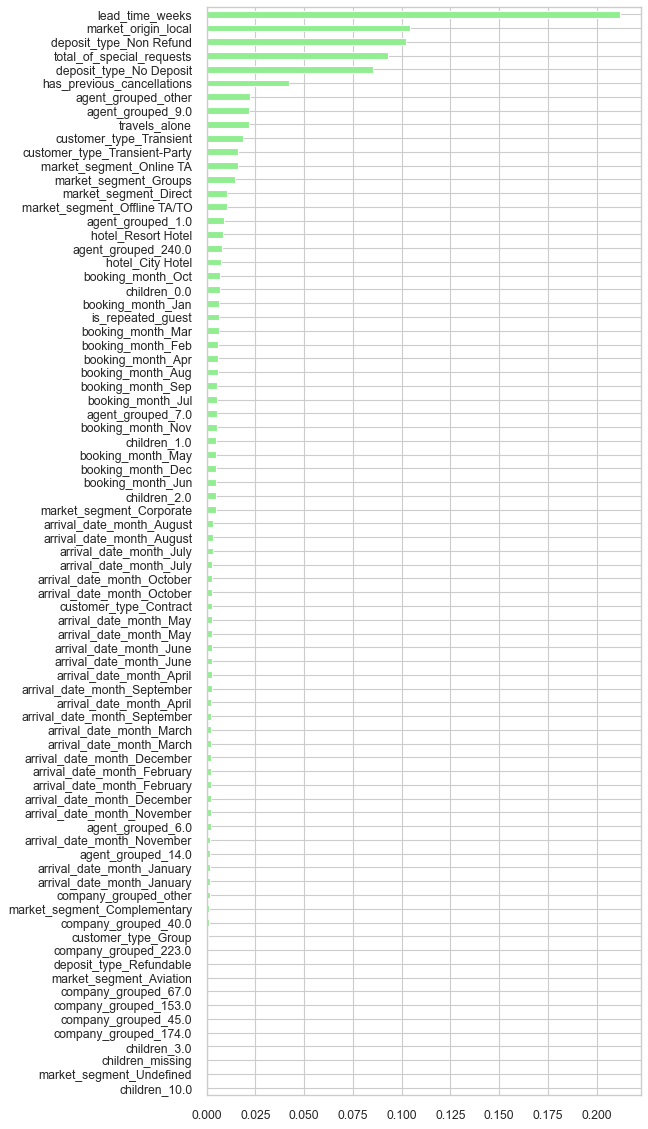

In [109]:
fig=plt.figure(figsize=(7, 18), dpi= 80, facecolor='w', edgecolor='k')
importances = pd.Series(data=best_model.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
importances_sorted.plot(kind = "barh", color = "lightgreen")
plt.show()

Lead time, market of ogirin, the deposit type and the number of spetial requests are the most important features when predicting for future cancelations.